## Hello, my Kaggle friends.   
Today I start a new competition with a prediction of house prices.   
It seems like this task will be more difficult, than a computing of Titanic passenger survival probability.  
However, let's start with import libs and data.

In [1]:
#common
import numpy as np
import pandas as pd 
import IPython
from IPython.display import display
import warnings
warnings.simplefilter('ignore')

#visualisation
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.style as style
from matplotlib.colors import ListedColormap

from sklearn.metrics import SCORERS
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle, resample
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA, IncrementalPCA

#regressors
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR, SVR
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool

In [2]:
train_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
subm = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')

#### Checking the datasets

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

The very first problem is that we have 80 features for prediction. And we have to pick only the important ones.   
The second question we must figure out are what to do with lots of missing values.  
And finally, we must turn all the 'sting' objects to numeric values.  

Ok, let's jump into it.

#### Pre-analysis.  

First, lets check the SalePrice column to clearly understand the distibution of prices.

In [5]:
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Mean price is around 180k USD, the most expensive house is for 775k USD and the cheapest is only for 34,9k USD. 50 quantile lies at 163k USD.  

Draw a distribution plot of prices.

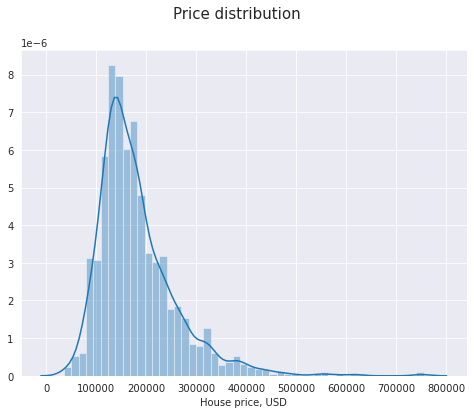

In [6]:
sns.set_style('darkgrid')

fig,ax = plt.subplots(1,1,figsize=(8,6))
sns.distplot(train_df['SalePrice'], ax=ax)

ax.set_xlabel('House price, USD')
plt.suptitle('Price distribution', size=15)
plt.show()

In [7]:
len(train_df.query('SalePrice > 500000'))

9

Only nine houses have a price more than 500000 $, seems like we can drop them as outliers in the future.

### Preprocessing

As we mentioned above, there are a lot of missing values in train and test datasets. Using the description text file, we will gently replace all the "NAN"s with proper values.

In [8]:
len(train_df), len(test_df)

(1460, 1459)

In [9]:
train_df.isna().sum().sort_values(ascending=False).head(10)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
dtype: int64

In [10]:
test_df.isna().sum().sort_values(ascending=False).head(10)

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageCond        78
GarageQual        78
GarageYrBlt       78
GarageFinish      78
dtype: int64

Four features (Pool quality, Misc Feature, Type of alley access and Fence quality) have more than 80% of missing values. It seems like these features don't affect the final sale price, and we may easily drop them from both datasets.

In [11]:
train_df = train_df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis=1)
test_df = test_df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis=1)

In [12]:
temp = train_df.isna().sum().sort_values()
temp[temp>=1]

Electrical        1
MasVnrArea        8
MasVnrType        8
BsmtQual         37
BsmtCond         37
BsmtFinType1     37
BsmtFinType2     38
BsmtExposure     38
GarageCond       81
GarageQual       81
GarageFinish     81
GarageType       81
GarageYrBlt      81
LotFrontage     259
FireplaceQu     690
dtype: int64

In [13]:
temp = test_df.isna().sum().sort_values()
temp[temp>=1]

GarageArea        1
KitchenQual       1
GarageCars        1
TotalBsmtSF       1
Exterior1st       1
Exterior2nd       1
BsmtFinSF1        1
BsmtFinSF2        1
SaleType          1
BsmtUnfSF         1
BsmtFullBath      2
Functional        2
Utilities         2
BsmtHalfBath      2
MSZoning          4
MasVnrArea       15
MasVnrType       16
BsmtFinType2     42
BsmtFinType1     42
BsmtExposure     44
BsmtQual         44
BsmtCond         45
GarageType       76
GarageFinish     78
GarageYrBlt      78
GarageQual       78
GarageCond       78
LotFrontage     227
FireplaceQu     730
dtype: int64

Let's combine two datasets and work with missing values faster.

In [14]:
full_df = pd.concat([train_df] + [test_df]).reset_index(drop=True)

In [15]:
full_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,6,2006,WD,Normal,NaN
2915,2916,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,4,2006,WD,Abnorml,NaN
2916,2917,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2006,WD,Abnorml,NaN
2917,2918,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,700,7,2006,WD,Normal,NaN


Don't forget to save the indexes of primary datasets.

In [16]:
train_ind = train_df['Id']
test_ind = test_df['Id']

In [17]:
test_ind

0       1461
1       1462
2       1463
3       1464
4       1465
        ... 
1454    2915
1455    2916
1456    2917
1457    2918
1458    2919
Name: Id, Length: 1459, dtype: int64

In [18]:
full_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000.0


In [19]:
temp = full_df.isna().sum().sort_values()
temp[temp>=1]

Electrical         1
SaleType           1
KitchenQual        1
BsmtFinSF1         1
BsmtUnfSF          1
TotalBsmtSF        1
GarageCars         1
Exterior2nd        1
Exterior1st        1
BsmtFinSF2         1
GarageArea         1
BsmtHalfBath       2
BsmtFullBath       2
Functional         2
Utilities          2
MSZoning           4
MasVnrArea        23
MasVnrType        24
BsmtFinType1      79
BsmtFinType2      80
BsmtQual          81
BsmtExposure      82
BsmtCond          82
GarageType       157
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageQual       159
LotFrontage      486
FireplaceQu     1420
SalePrice       1459
dtype: int64

##### Most common categorial features

Here we have some categorical features (such as FireplaceQu and GarageQual for example), some numeric features (LotFrontage and MasVnrArea). 
First, we figure out with categorical ones.

In [20]:
full_df['FireplaceQu'] = full_df['FireplaceQu'].fillna('None')
full_df['GarageQual'] = full_df['GarageQual'].fillna('None')
full_df['GarageFinish'] = full_df['GarageFinish'].fillna('None')
full_df['GarageCond'] = full_df['GarageCond'].fillna('None')
full_df['GarageType'] = full_df['GarageType'].fillna('None')
full_df['BsmtExposure'] = full_df['BsmtExposure'].fillna('None')
full_df['BsmtQual'] = full_df['BsmtQual'].fillna('None')
full_df['BsmtCond'] = full_df['BsmtCond'].fillna('None')
full_df['BsmtFinType2'] = full_df['BsmtFinType2'].fillna('None')
full_df['BsmtFinType1'] = full_df['BsmtFinType1'].fillna('None')
full_df['MasVnrType'] = full_df['MasVnrType'].fillna('None')
full_df['BsmtFinType2'] = full_df['BsmtFinType2'].fillna('None')

In [21]:
full_df.isna().sum().sort_values(ascending=False).head(20)

SalePrice       1459
LotFrontage      486
GarageYrBlt      159
MasVnrArea        23
MSZoning           4
Utilities          2
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
SaleType           1
BsmtFinSF1         1
Exterior1st        1
BsmtFinSF2         1
BsmtUnfSF          1
GarageArea         1
GarageCars         1
TotalBsmtSF        1
Exterior2nd        1
KitchenQual        1
Electrical         1
dtype: int64

Keep in mind, that we dont need to fill SalePrice column! 

---

##### LotFrontage
Linear feet of street connected to property. What if this feature depends of LotArea (Lot size in square feet).

             LotFrontage   LotArea
LotFrontage     1.000000  0.489896
LotArea         0.489896  1.000000


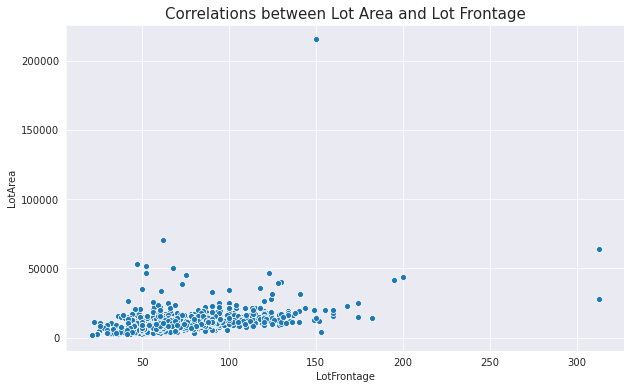

In [22]:
temp = full_df[['LotFrontage','LotArea']]

plt.figure(figsize=(10,6))
sns.scatterplot(x=temp['LotFrontage'], y=temp['LotArea'])
plt.title('Correlations between Lot Area and Lot Frontage', size=15);

print(temp.corr())

We will fill missing LotFrontage values with square root of LotArea.

In [23]:
full_df['LotFrontage'] = full_df['LotFrontage'].fillna(np.sqrt(full_df['LotArea']))

             LotFrontage   LotArea
LotFrontage     1.000000  0.626687
LotArea         0.626687  1.000000


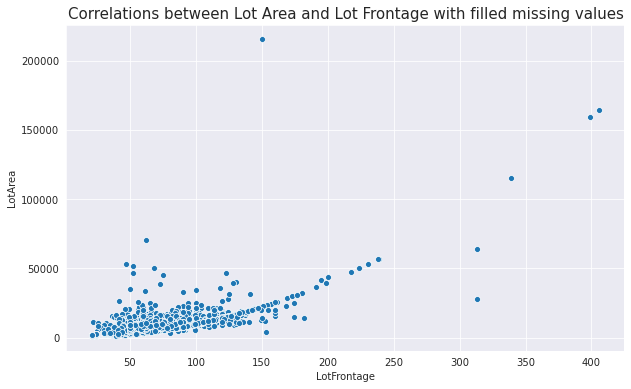

In [24]:
temp = full_df[['LotFrontage','LotArea']]

plt.figure(figsize=(10,6))
sns.scatterplot(x=temp['LotFrontage'], y=temp['LotArea'])
plt.title('Correlations between Lot Area and Lot Frontage with filled missing values', size=15);

print(temp.corr())

We can observe a clear line of new meanings. Let's see if it will affect the predictions in the future. 

---

##### Garages and cars

What year garages were built?

In [25]:
temp_year = full_df[['GarageYrBlt', 'YearBuilt']]

temp_year

,GarageYrBlt,YearBuilt
0,2003.0,2003
1,1976.0,1976
2,2001.0,2001
3,1998.0,1915
4,2000.0,2000
...,...,...
2914,NaN,1970
2915,1970.0,1970
2916,1960.0,1960
2917,NaN,1992


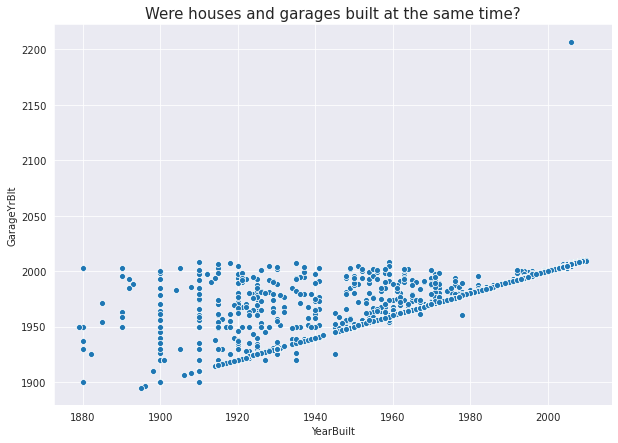

In [26]:
plt.figure(figsize=(10,7))
sns.scatterplot(temp_year['YearBuilt'], temp_year['GarageYrBlt'])
plt.title('Were houses and garages built at the same time?', size=15);

Nope. We can see, that lot of garages were attached to old houses few years later from the building date.  
After 1980, almost all new houses have a garage by default.  
Look, somebody want to build a garage after 2200! We must to change it!


In [27]:
full_df.query('GarageYrBlt>2100')['GarageYrBlt']

2592    2207.0
Name: GarageYrBlt, dtype: float64

Ah, what a pity mistake.

In [28]:
full_df.loc[full_df['GarageYrBlt'] == 2207,'GarageYrBlt'] = 2007

By the way, let's fill all the missing years with the date of the houses were built.

In [29]:
full_df['GarageYrBlt'] = full_df['GarageYrBlt'].fillna(full_df['YearBuilt'])

In [30]:
full_df.isna().sum().sort_values(ascending=False).head(10)

SalePrice       1459
MasVnrArea        23
MSZoning           4
Utilities          2
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
BsmtFinSF1         1
GarageArea         1
KitchenQual        1
dtype: int64

Garage cars and Garrage area, next, please.

In [31]:
full_df['GarageArea'] = full_df.groupby('GarageType')['GarageArea'].transform(lambda x: x.fillna(value=x.median()))

I think there should be a strong correlation between Garage Area and number of places for cars.

In [32]:
full_df['GarageCars'].corr(full_df['GarageArea'])

0.8897004146858453

Yes!

In [33]:
full_df.loc[full_df['GarageCars'].isna()]['GarageArea']

2576    399.5
Name: GarageArea, dtype: float64

This garage has a vast area, and we may predict it can accommodate...

In [34]:
full_df.loc[full_df['GarageArea'] == 400]['GarageCars'].value_counts()

2.0    57
1.0     1
Name: GarageCars, dtype: int64

...two cars.

In [35]:
full_df['GarageCars'] = full_df['GarageCars'].fillna(2)

##### Veneer area

In [36]:
full_df.loc[full_df['MasVnrArea'].isna()][['MasVnrArea', 'MasVnrType']]

,MasVnrArea,MasVnrType
234,NaN,None
529,NaN,None
650,NaN,None
936,NaN,None
973,NaN,None
977,NaN,None
1243,NaN,None
1278,NaN,None
1691,NaN,None
1706,NaN,None


Ok, we will replace missing Veneer area with O.

In [37]:
full_df['MasVnrArea'] = full_df['MasVnrArea'].fillna(0)

##### We need more different zones, Milord

In [38]:
full_df.loc[full_df['MSZoning'].isna()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1915,1916,30,NaN,109.000000,21780,Grvl,Reg,Lvl,NaN,Inside,...,0,0,0,0,0,3,2009,ConLD,Normal,NaN
2216,2217,20,NaN,80.000000,14584,Pave,Reg,Low,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Abnorml,NaN
2250,2251,70,NaN,237.907545,56600,Pave,IR1,Low,AllPub,Inside,...,0,0,0,0,0,1,2008,WD,Normal,NaN
2904,2905,20,NaN,125.000000,31250,Pave,Reg,Lvl,AllPub,Inside,...,135,0,0,0,0,5,2006,WD,Normal,NaN


In [39]:
full_df['MSZoning'].value_counts()

RL         2265
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

We just fill missing Zoning values with 'RL'.

In [40]:
full_df['MSZoning'] = full_df['MSZoning'].fillna(value='RL')

##### Utilities

What about missing availible utilities? Let's check the year of the build.

In [41]:
full_df.loc[full_df['Utilities'].isna()]['YearBuilt'] 

1915    1910
1945    1952
Name: YearBuilt, dtype: int64

What kind of utilities was available at those times?

In [42]:
print(full_df.loc[full_df['YearBuilt'] == 1910]['Utilities'].value_counts())
print(full_df.loc[full_df['YearBuilt'] == 1952]['Utilities'].value_counts())

AllPub    42
Name: Utilities, dtype: int64
AllPub    17
Name: Utilities, dtype: int64


Comfort houses, by the way. So, fill NANs with 'AllPub' values.

In [43]:
full_df['Utilities'] = full_df['Utilities'].fillna(value='AllPub')

##### Time to bath (not bass)

In [44]:
full_df['BsmtHalfBath'].value_counts()

0.0    2742
1.0     171
2.0       4
Name: BsmtHalfBath, dtype: int64

In [45]:
full_df['BsmtFullBath'].value_counts()

0.0    1705
1.0    1172
2.0      38
3.0       2
Name: BsmtFullBath, dtype: int64

In [46]:
full_df.query('BsmtHalfBath=="nan" or BsmtFullBath=="nan"')[['BsmtHalfBath', 'BsmtFullBath', 'YearBuilt']]

,BsmtHalfBath,BsmtFullBath,YearBuilt
2120,NaN,NaN,1946
2188,NaN,NaN,1959


In [47]:
full_df.query('YearBuilt == 1959')['BsmtHalfBath'].value_counts()
#full_df.query('YearBuilt == 1946')['BsmtHalfBath']

0.0    39
1.0     3
Name: BsmtHalfBath, dtype: int64

Let's pretend, there are no bath at these houses.

In [48]:
full_df[['BsmtHalfBath', 'BsmtFullBath']] = full_df[['BsmtHalfBath', 'BsmtFullBath']].fillna(value=0)

Next, please.   
##### Functional

In [49]:
full_df.Functional.value_counts()

Typ     2717
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64

In [50]:
full_df['Functional'] = full_df['Functional'].fillna('Typ')

In [51]:
full_df.isna().sum().sort_values(ascending=False).head(10)

SalePrice      1459
BsmtFinSF2        1
TotalBsmtSF       1
BsmtFinSF1        1
Electrical        1
Exterior2nd       1
Exterior1st       1
KitchenQual       1
BsmtUnfSF         1
SaleType          1
dtype: int64

Square feets

In [52]:
full_df['BsmtFinSF2'].value_counts()

0.0      2571
294.0       5
180.0       5
162.0       3
539.0       3
         ... 
196.0       1
904.0       1
456.0       1
624.0       1
823.0       1
Name: BsmtFinSF2, Length: 272, dtype: int64

In [53]:
full_df['BsmtFinSF2'] = full_df['BsmtFinSF2'].fillna(0)

In [54]:
full_df.loc[full_df['BsmtFinSF1'].isna()]['BsmtFinType1']

2120    None
Name: BsmtFinType1, dtype: object

In [55]:
full_df['BsmtFinSF1'] = full_df['BsmtFinSF1'].fillna(0)

In [56]:
full_df.loc[full_df['TotalBsmtSF'].isna(), 'BsmtFinSF1']

2120    0.0
Name: BsmtFinSF1, dtype: float64

In [57]:
full_df[['TotalBsmtSF', 'BsmtFinSF1']]

,TotalBsmtSF,BsmtFinSF1
0,856.0,706.0
1,1262.0,978.0
2,920.0,486.0
3,756.0,216.0
4,1145.0,655.0
...,...,...
2914,546.0,0.0
2915,546.0,252.0
2916,1224.0,1224.0
2917,912.0,337.0


In [58]:
full_df['TotalBsmtSF'].corr(full_df['SalePrice'])

0.6135805515591954

In [59]:
full_df.isna().sum().sort_values(ascending=False).head(10)

SalePrice      1459
KitchenQual       1
TotalBsmtSF       1
Electrical        1
Exterior2nd       1
Exterior1st       1
BsmtUnfSF         1
SaleType          1
Street            0
BsmtQual          0
dtype: int64

In [60]:
full_df.loc[full_df['TotalBsmtSF'].isna()]['OverallQual']

2120    4
Name: OverallQual, dtype: int64

In [61]:
full_df.loc[full_df['OverallQual']==4]['BsmtUnfSF'].value_counts()

0.0       40
546.0      6
624.0      4
576.0      3
600.0      3
          ..
297.0      1
88.0       1
715.0      1
1040.0     1
863.0      1
Name: BsmtUnfSF, Length: 155, dtype: int64

In [62]:
full_df[['TotalBsmtSF','BsmtUnfSF']] = full_df[['TotalBsmtSF','BsmtUnfSF']].fillna(0)

Missing sale type

In [63]:
full_df['SaleType'].value_counts()

WD       2525
New       239
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
Name: SaleType, dtype: int64

In [64]:
full_df['SaleType'] = full_df['SaleType'].fillna('WD')

What a beautiful exterior!

In [65]:
full_df.loc[full_df['Exterior2nd'].isna()][['Exterior2nd','Exterior1st','YearBuilt']]

,Exterior2nd,Exterior1st,YearBuilt
2151,NaN,NaN,1940


This house was built in 1940. Which type of material was more popular at that time?

In [66]:
full_df.loc[full_df['YearBuilt'] == 1940][['Exterior1st', 'Exterior2nd', 'MSZoning']]

,Exterior1st,Exterior2nd,MSZoning
165,Wd Sdng,Wd Sdng,RL
250,Wd Sdng,Plywood,RL
268,VinylSd,VinylSd,RM
308,VinylSd,VinylSd,RL
354,Wd Sdng,MetalSd,RL
361,MetalSd,MetalSd,RL
394,MetalSd,MetalSd,RL
402,Wd Sdng,Wd Sdng,RL
418,MetalSd,MetalSd,RL
562,WdShing,Wd Shng,RL


In [67]:
full_df.loc[full_df['YearBuilt'] == 1940]['Exterior1st'].value_counts()

Wd Sdng    13
MetalSd    11
VinylSd     9
Stucco      1
WdShing     1
Name: Exterior1st, dtype: int64

In [68]:
full_df.loc[full_df['YearBuilt'] == 1940]['Exterior2nd'].value_counts()

MetalSd    12
Wd Sdng    10
VinylSd     9
Stucco      1
Wd Shng     1
Plywood     1
HdBoard     1
Name: Exterior2nd, dtype: int64

As we can see, materials for both exteriors are the same as usual. Wood and metal were the most common materials.

Let's pretend, in this case, there are metal siding.

In [69]:
full_df[['Exterior1st','Exterior2nd']] = full_df[['Exterior1st','Exterior2nd']].fillna('MetalSd')

##### Air is electrising!

In [70]:
full_df.loc[full_df['Electrical'].isna()]['YearBuilt']

1379    2006
Name: YearBuilt, dtype: int64

This house is almost new.

In [71]:
full_df.loc[full_df['YearBuilt'] == 2006]['Electrical'].value_counts()

SBrkr    137
Name: Electrical, dtype: int64

There is no other options.

In [72]:
full_df['Electrical'] = full_df['Electrical'].fillna(value='SBrkr')

##### Finaly, time for the most important area into entire house!

In [73]:
full_df.loc[full_df['KitchenQual'].isna()]['YearBuilt']

1555    1917
Name: YearBuilt, dtype: int64

In [74]:
full_df.loc[full_df['YearBuilt']==1917][['KitchenQual', 'OverallCond']]

,KitchenQual,OverallCond
1248,TA,5
1555,NaN,3
1818,Ex,7


In [75]:
full_df.loc[full_df['OverallCond']==3]['KitchenQual'].value_counts()

TA    40
Fa     6
Gd     3
Name: KitchenQual, dtype: int64

Ok, we just fill last missing value with 'TA'.

In [76]:
full_df['KitchenQual'] = full_df['KitchenQual'].fillna(value='TA')

Checking the full dataset.

In [77]:
full_df.isna().sum().sort_values()

Id                 0
Functional         0
TotRmsAbvGrd       0
KitchenQual        0
KitchenAbvGr       0
                ... 
Exterior1st        0
RoofMatl           0
RoofStyle          0
ExterCond          0
SalePrice       1459
Length: 77, dtype: int64

Good, only price values, we must predict, are still missing.

### Feature selection  

For the first try, let's choose important features manually.

In [80]:
full_df_ref_man = full_df[[
                           'Street',
                           'Exterior1st',
                           'KitchenQual',
                           'Heating',
    
                           'MSZoning',
                           'YearBuilt',
                           'Neighborhood',
                           'Condition1',
                           'BldgType',
                           'HouseStyle',
                           'OverallQual',
                           'OverallCond',
                           'ExterQual',
                           'ExterCond', 
                           'BsmtQual',
                           'BsmtCond',
                           'CentralAir',
                           'HeatingQC',
                           'Electrical',
                           '1stFlrSF',
                           '2ndFlrSF',
                           'GrLivArea',
                           'FullBath',
                           'BedroomAbvGr',
                           'KitchenAbvGr',
                           'Functional',
                           'GarageType',
                           'GarageQual',
                           'OpenPorchSF',
                           'PoolArea',
                           'SaleType',
                           'SaleCondition',
                           'SalePrice'
                          ]]

In [304]:
full_df_ver2 = full_df[[
                            ### This features were added during the last attempt ###
                           'LotFrontage',
                           'LotArea',
                           'Condition2',
                           'YearRemodAdd',
                           'MasVnrArea',
                           'BsmtFinType1',
                           'TotalBsmtSF',
                           'TotRmsAbvGrd',
                           'Fireplaces',
                           'GarageYrBlt',
                           'GarageCars',
    
                            ### Current best result was performed with these features ### 
                           'Street',
                           'Exterior1st',
                           'KitchenQual',
                           'Heating',
                            
                            ### I also removed some features from this list ###
                           'MSZoning',
                           'YearBuilt',
                           'Neighborhood',
                           'Condition1',
                           'BldgType',
                           'HouseStyle',
                           'OverallQual',
                           'OverallCond',
                           'ExterQual',
                           'ExterCond', 
                           'BsmtQual',
                           'BsmtCond',
                           'CentralAir',
                           'HeatingQC',
                           'Electrical',
                           '1stFlrSF',
                           '2ndFlrSF',
                           'GrLivArea',
                           #'FullBath',
                           #'BedroomAbvGr',
                           #'KitchenAbvGr',
                           'Functional',
                           'GarageType',
                           #'GarageQual',
                           #'OpenPorchSF',
                           #'PoolArea',
                           'SaleType',
                           'SaleCondition',
                           'SalePrice'
                          ]]

In [305]:
full_df_ref_man.index = full_df["Id"]
full_df_ver2.index = full_df['Id']
full_df_all.index = full_df['Id']

In [306]:
full_df_ver2.head()

,LotFrontage,LotArea,Condition2,YearRemodAdd,MasVnrArea,BsmtFinType1,TotalBsmtSF,TotRmsAbvGrd,Fireplaces,GarageYrBlt,...,HeatingQC,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,Functional,GarageType,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,Norm,2003,196.0,GLQ,856.0,8,0,2003.0,...,Ex,SBrkr,856,854,1710,Typ,Attchd,WD,Normal,208500.0
2,80.0,9600,Norm,1976,0.0,ALQ,1262.0,6,1,1976.0,...,Ex,SBrkr,1262,0,1262,Typ,Attchd,WD,Normal,181500.0
3,68.0,11250,Norm,2002,162.0,GLQ,920.0,6,1,2001.0,...,Ex,SBrkr,920,866,1786,Typ,Attchd,WD,Normal,223500.0
4,60.0,9550,Norm,1970,0.0,ALQ,756.0,7,1,1998.0,...,Gd,SBrkr,961,756,1717,Typ,Detchd,WD,Abnorml,140000.0
5,84.0,14260,Norm,2000,350.0,GLQ,1145.0,9,1,2000.0,...,Ex,SBrkr,1145,1053,2198,Typ,Attchd,WD,Normal,250000.0


#### Features encoding 

Using dummy encoding, we will replace all categotial features with 1 and 0 values.

In [307]:
full_df_upd_0 = pd.get_dummies(full_df_ref_man, drop_first=True)
full_df_enc_2 = pd.get_dummies(full_df_ver2, drop_first=True)

Also, for some gradient boosting machines, let's encode categorial string values to integer ones.

In [308]:
enc = OrdinalEncoder()

In [309]:
full_df_ver2.columns

Index(['LotFrontage', 'LotArea', 'Condition2', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinType1', 'TotalBsmtSF', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'Street', 'Exterior1st', 'KitchenQual',
       'Heating', 'MSZoning', 'YearBuilt', 'Neighborhood', 'Condition1',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'ExterQual',
       'ExterCond', 'BsmtQual', 'BsmtCond', 'CentralAir', 'HeatingQC',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'Functional',
       'GarageType', 'SaleType', 'SaleCondition', 'SalePrice'],
      dtype='object')

In [310]:
cat_features = ['LotFrontage', 'Condition2',
       'BsmtFinType1', 'Fireplaces', 'SaleType', 'SaleCondition', 'Street',
       'Exterior1st', 'KitchenQual', 'Heating', 'MSZoning', 
       'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       'CentralAir', 'HeatingQC', 'Electrical', 'Functional', 'GarageType', 'SaleCondition']

In [311]:
full_df_ver2_cat = full_df_ver2.copy()
full_df_ver2_cat[cat_features] = enc.fit_transform(full_df_ver2_cat[cat_features]).astype('int')

Divide full dataset into train and test subsets again. Also pick out the target values ('SalePrice')

In [93]:
RND_ST = 42

In [312]:
X_train_0 = full_df_upd_0.query('index in @train_ind').drop(['SalePrice'], axis=1).reset_index(drop=True)
X_test_0 = full_df_upd_0.query('index in @test_ind').drop(['SalePrice'], axis=1).reset_index(drop=True)

X_train_2 = full_df_enc_2.query('index in @train_ind').drop(['SalePrice'], axis=1).reset_index(drop=True)
X_test_2 = full_df_enc_2.query('index in @test_ind').drop(['SalePrice'], axis=1).reset_index(drop=True)

X_train_cat = full_df_ver2_cat.query('index in @train_ind').drop(['SalePrice'], axis=1).reset_index(drop=True).astype('int')
X_test_cat = full_df_ver2_cat.query('index in @test_ind').drop(['SalePrice'], axis=1).reset_index(drop=True).astype('int')

y_train = full_df_upd_0.query('index in @train_ind')['SalePrice'].reset_index(drop=True)


### Validation subsets

X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train_0, y_train, test_size=0.2, random_state=RND_ST) 
X_train_sub_2, X_valid_sub_2, y_train_sub_2, y_valid_sub_2 = train_test_split(X_train_2, y_train, test_size=0.2, random_state=RND_ST) 
X_train_sub_c, X_valid_sub_c, y_train_sub_c, y_valid_sub_c = train_test_split(X_train_cat, y_train, test_size=0.2, random_state=RND_ST) 

### Model selection  

Looking for the best hyperparameters.

In [96]:
def mae(model, X_train, X_test, y_train, y_test):
    
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print('MAE train = ', mean_absolute_error(y_train, y_train_pred))
    print('MAE test = ', mean_absolute_error(y_test, y_test_pred))

In [97]:
RND_ST = 42

In [444]:
### Random Forest Regressor ###

rfr = RandomForestRegressor(n_jobs=-1, random_state=RND_ST)

params_rfr = dict(n_estimators=range(10,500,10),
                  max_features=range(5, 30),
                  max_leaf_nodes = [1,5,10,20])


### Gradient Boosting Regressor ###

gbr = GradientBoostingRegressor(random_state=RND_ST)

params_gbr = dict(n_estimators=range(200,1000,5),
                  max_features=range(5, 40),
                  max_depth=[0,2,3,4],
                  learning_rate = [0.01, 0.1, 0.5, 1],
                  )

params_gbr_nest = dict(n_estimators=range(200,900,5))

params_gbr_other = dict(#max_features=range(10, 50),
                        max_depth=[2,3,4],
                        learning_rate = [0.1, 0.3, 0.5, 1],
                        max_features = ['auto', 'sqrt', 'log2'])

### xgboost ### 

dtrain_sub = xgb.DMatrix(data=X_train_sub_2, label=y_train_sub_2)
dtrain_full = xgb.DMatrix(data=X_train_2, label=y_train)

dvalid_sub = xgb.DMatrix(data=X_valid_sub_2)
dtest = xgb.DMatrix(data=X_test_2)

### LightGBM ###

train_data = lgb.Dataset(X_train_sub_c, label=y_train_sub_c, categorical_feature=cat_features, free_raw_data=False)
train_data_full = lgb.Dataset(X_train_cat, label=y_train, categorical_feature=cat_features, free_raw_data=False) 

### CatBoost ###

catboost_train = Pool(X_train_sub_c, y_train_sub_c, cat_features=cat_features)
catboost_train_full = Pool(X_train_cat, y_train, cat_features=cat_features)

Create the Randomized Search function with 5 folds. We will use MAE as the main searching metric.

In [264]:
def random_search(model, params, feat, targ):
    
    
    search = RandomizedSearchCV(model, params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    search.fit(feat, targ)
    
    print(search.best_score_)
    print(search.best_params_)

In [265]:
def grid_search(model, params, feat, targ):
    
    
    search = GridSearchCV(model, params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
    search.fit(feat, targ)
    
    print(search.best_score_)
    print(search.best_params_)

---

#### Gradient boosting

In [314]:
random_search(gbr, params_gbr, X_train_2, y_train)

-15847.930707420048
{'n_estimators': 680, 'max_features': 26, 'max_depth': 4, 'learning_rate': 0.01}


MAE = 15157 - nice value with updated features.  
Let's try to find better metric with two-steps grid search.

In [266]:
#grid_search(gbr, params_gbr_nest, X_train_2, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 11.4min finished


-15884.959146315576
{'n_estimators': 385}


In [315]:
gbr_est = GradientBoostingRegressor(n_estimators=265, random_state=RND_ST)

gbr_est_1 = GradientBoostingRegressor(n_estimators=385, random_state=RND_ST)

gbr_est_2 = GradientBoostingRegressor(n_estimators=385, random_state=RND_ST)

In [268]:
#grid_search(gbr_est_1, params_gbr_other, X_train_2, y_train)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed:  3.4min finished


-15532.325927041096
{'learning_rate': 0.1, 'max_depth': 3, 'max_features': 28}


In [316]:
grid_search(gbr_est_2, params_gbr_other, X_train_2, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.1min finished


-15901.400608550659
{'learning_rate': 0.1, 'max_depth': 2, 'max_features': 'auto'}


In [343]:
gbr_new = GradientBoostingRegressor(n_estimators=265, max_depth=4, max_features=28, random_state=RND_ST)
gbr_new_2 = GradientBoostingRegressor(n_estimators=385, max_depth=3, max_features=24, random_state=RND_ST)
gbr_new_3 = GradientBoostingRegressor(n_estimators=700, max_depth=4, max_features=24, random_state=RND_ST, learning_rate=0.3)

In [331]:
mae(gbr_new_2, X_train_sub_2, X_valid_sub_2, y_train_sub_2, y_valid_sub_2)

MAE train =  7402.661866819601
MAE test =  16096.968041196978


In [344]:
mae(gbr_new_3, X_train_sub_2, X_valid_sub_2, y_train_sub_2, y_valid_sub_2)

MAE train =  249.00029248369916
MAE test =  18379.198446714254


In [276]:
### Best metrics for gradient boosting regressor
### MAE train =  7508.041979472287
### MAE test =  16559.574486690173

---

#### LightGBM

In [110]:
param = {'num_leaves': 70, 
         'objective':'regression',
         'min_data_in_leaf':23,
         'max_depth':3,
         'learning_rate':0.1,
         'num_iterations':630,
         #'max_bin':5000,
         #'verbosity':0,
         'min_split_gain':90,
         'random_state':RND_ST
            }

num_round = 20

In [111]:
lgbm = lgb.train(param, train_data, num_round)

y_tr = lgbm.predict(X_train_sub_c)
y_val = lgbm.predict(X_valid_sub_c)

print('Train mae = ', mean_absolute_error(y_train_sub_c, y_tr))
print('Valid mae = ', mean_absolute_error(y_valid_sub_c, y_val))

Train mae =  8468.239997843708
Valid mae =  18190.658792767892


In [112]:
## Best achieved metrics with LightGBM
## Train mae =  6460.697903755476
## Valid mae =  17390.618087551717

In [113]:
mod = lgb.train(param, train_data_full, num_round)

pred_fin = pd.DataFrame(np.around(mod.predict(X_test_cat)), columns=['SalePrice'])


submission = pd.DataFrame(subm['Id'])

submission = submission.join(pred_fin)

submission.to_csv('/kaggle/working/light.csv', index=False)

#### XGBoost

In [459]:
params_xgb = {
    'max_depth':6, 
    'eta':.16, 
    'min_child_weight':2,
    'colsample_bytree':0.8,
    'subsample':1,
    'seed':RND_ST, 
   }

num_round = 52

In [466]:
xgboost = xgb.train(params_xgb, dtrain_sub, num_round)

y_tr = xgboost.predict(dtrain_sub)
y_val = xgboost.predict(dvalid_sub)

print('Train mae = ', mean_absolute_error(y_train_sub, y_tr))
print('Valid mae = ', mean_absolute_error(y_test_sub, y_val))

Train mae =  6033.02468161387
Valid mae =  15837.233826519692


In [117]:
### Train mae =  6033.02468161387
### Valid mae =  15837.233826519692

In [464]:
mod = xgb.train(params_xgb, dtrain_full, num_round)

pred_fin = pd.DataFrame(np.around(mod.predict(dtest)), columns=['SalePrice'])


submission = pd.DataFrame(subm['Id'])

submission = submission.join(pred_fin)

submission.to_csv('/kaggle/working/xgb_01.csv', index=False)

#### CatBoost

In [440]:
catboost = CatBoostRegressor(
                          iterations=1220, 
                          depth=4, 
                          learning_rate=0.1, 
                          loss_function='RMSE', 
                          subsample=0.98,
                          grow_policy='Depthwise',
                          
                          
                          ###
                          verbose=0, 
                          random_seed=RND_ST)

In [441]:
catboost.fit(catboost_train)

cat_y_tr = catboost.predict(X_train_sub_c)
cat_y_val = catboost.predict(X_valid_sub_c)

print('Train mae = ', mean_absolute_error(y_train_sub_c, cat_y_tr))
print('Valid mae = ', mean_absolute_error(y_valid_sub_c, cat_y_val))

Train mae =  6667.339339208705
Valid mae =  16555.888137054444


In [417]:
### CatBoost best
### Train mae =  6801.760501396707
### Valid mae =  16092.458600763324

In [121]:
catboost_1 = CatBoostRegressor(
                          iterations=300, 
                          #depth=4, 
                          #learning_rate=0.1, 
                          #loss_function='RMSE', 
                          #subsample=0.4,
                          #grow_policy='Depthwise',
                          
                          
                          ###
                          verbose=0, 
                          random_seed=RND_ST)


In [122]:
catboost_1.fit(catboost_train_1)

cat_y_tr = catboost_1.predict(X_train_cb_sub)
cat_y_val = catboost_1.predict(X_valid_cb_sub)

print('Train mae = ', mean_absolute_error(y_train_cb_sub, cat_y_tr))
print('Valid mae = ', mean_absolute_error(y_valid_cb_sub, cat_y_val))

Train mae =  12374.274513403961
Valid mae =  19096.89365948236


13993.977074839253
18283.774658686176
380


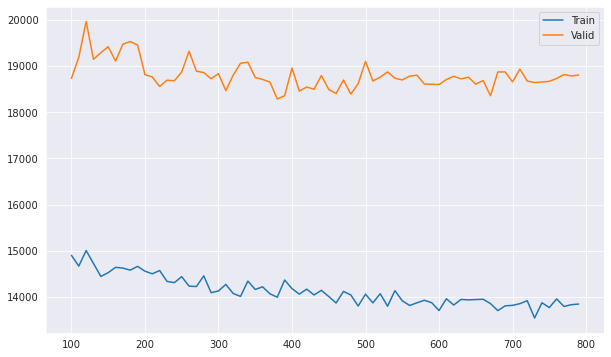

In [138]:
mae_tr = []
mae_val = []
estim = []

for i in range(100,800,10):
    mod = CatBoostRegressor(
                          iterations=i,
                          depth=4,
                          verbose=0, 
                          random_seed=RND_ST)
    mod.fit(catboost_train_1)
    
    cat_y_tr = mod.predict(X_train_cb_sub)
    cat_y_val = mod.predict(X_valid_cb_sub)

    mae_tr.append(mean_absolute_error(y_train_cb_sub, cat_y_tr))
    mae_val.append(mean_absolute_error(y_valid_cb_sub, cat_y_val))
    estim.append(i)
    
plt.figure(figsize=(10,6))
sns.lineplot(x=estim, y=mae_tr, label='Train')
sns.lineplot(x=estim, y=mae_val, label='Valid');

print(mae_tr[mae_tr.index(min(mae_val))])
print(min(mae_val))
print(estim[mae_val.index(min(mae_val))])

### Fit and test the final model

In [127]:
model_rfr = RandomForestRegressor(n_estimators=270, max_leaf_nodes=20, max_features=23, n_jobs=-1, random_state=RND_ST)

In [128]:
model_gbr = GradientBoostingRegressor(n_estimators=590, max_features=24, max_depth=6, learning_rate=0.08, random_state=RND_ST)

In [129]:
model_gbr_ = GradientBoostingRegressor(n_estimators=810, max_features=24, max_depth=3, learning_rate=0.1, random_state=RND_ST)

In [130]:
model_gbr_more_feat = GradientBoostingRegressor(n_estimators=2000, max_features=26, max_depth=2, learning_rate=0.1, random_state=RND_ST)

In [284]:
gbr_new.fit(X_train_0, y_train)
pred = gbr_new.predict(X_train_0)
mean_absolute_error(y_train, pred)

10013.769124650875

In [132]:
mae(gbr_new, X_train_sub, X_test_sub, y_train_sub, y_test_sub)

MAE train =  7545.255849439418
MAE test =  17515.674866522506


In [133]:
### best mae 9095 7029
### best mae_train 6672
### best_mae_tesr 17325

### Make a prediction, create the submission file.

#### Prediction for sklearn models

In [134]:
def prediction(model, feat_tr, feat_test, targ_tr):
    
    model.fit(feat_tr, targ_tr)
    pred_final = pd.DataFrame((model.predict(feat_test)), columns=['SalePrice'])
    
    return(pred_final)

In [323]:
pred = np.around(prediction(gbr_new_3, X_train_2, X_test_2, y_train))

submission = pd.DataFrame(subm['Id'])

submission = submission.join(pred)

submission.to_csv('/kaggle/working/grad_boost_new_3.csv', index=False)

In [322]:
submission

,Id,SalePrice
0,1461,124644.0
1,1462,166701.0
2,1463,182471.0
3,1464,196125.0
4,1465,178251.0
...,...,...
1454,2915,79565.0
1455,2916,84813.0
1456,2917,169030.0
1457,2918,128245.0


#### Prediction for boosting models

In [463]:
mod = catboost.fit(catboost_train_full)

pred_fin = pd.DataFrame(np.around(mod.predict(X_test_cat)), columns=['SalePrice'])


submission = pd.DataFrame(subm['Id'])

submission = submission.join(pred_fin)

submission.to_csv('/kaggle/working/catboost_01.csv', index=False)

In [367]:
submission.head()

,Id,SalePrice
0,1461,116221.0
1,1462,160810.0
2,1463,188046.0
3,1464,193366.0
4,1465,175365.0


## Scoreboard 

0.12868 - Rank 1645 - catboost, X_train_cat  
0.12886 - Rank 1654 - catboost, X_train_cat  
0.12910 - Rank 1683 - gbr_new_2, X_train_2  
0.13866 - Rank 2403 - gbr_new, X_train_0 (more_features)  
0.13934 - Rank 2433 - catboost, X_train_c  
0.14346 - Rank 2755 - model_gbr_ with updated params, X_train_0 + Year feature.  
0.14631 - Rank 2922 - model_gbr with updated params, X_train_0  
0.15217 - Rank 3330 - model_gbr, X_train_0  
0.20628 - Rank 4340 - very first try, with no features engeneering and just Random Forest Regressor

#### Best models  

gbr_new = GradientBoostingRegressor(n_estimators=265, max_depth=4, max_features=28, random_state=RND_ST)    

gbr_new_2 = GradientBoostingRegressor(n_estimators=385, max_depth=3, max_features=24, random_state=RND_ST) 

catboost = CatBoostRegressor(
                         iterations=1300, 
                          depth=4, 
                          learning_rate=0.1, 
                          loss_function='RMSE', 
                          subsample=0.8,
                          grow_policy='Depthwise',
                          verbose=0, 
                          random_seed=RND_ST))
